In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 
from joblib import Parallel, delayed
import glob
from os import walk

In [2]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [3]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [4]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    
    #finding frequency of each chirp duration
    x = np.array(pd_df.CDUR)
    x = x.astype(int)
    (uniq, freq) = (np.unique(x, return_counts=True))
    xa = np.array([uniq,freq])

    #finding the bracket of 61 values with the most data points
    if (np.max(xa[0]) - np.min(xa[0])) > 60: #Checking if the range of available points exceeds interested bracket size
        jo = np.zeros(np.max(xa[0]))
        jo[xa[0]-1] = freq
        jo2 = []
        for i in range(30,len(jo)-30):
            jo2.append([i, np.sum(jo[i-30:i+30])])
        jo2 = np.array(jo2).T
        j = np.argmax(jo2[1])
        val = j + 30

        #filtering down to values in the bracket calculated above
        x = pd_df.CDUR
        x1 = x>=(val-30)
        xa = pd_df[x1]
        x2 = xa.CDUR<=(val+30)
        xb = xa[x2]
    
    else: 
        xb = pd_df
    
    #repeating the same procedure for the values in chirp pause
    pd_df = xb
    x = np.array(pd_df.CPAU)
    x = x.astype(int)
    (uniq, freq) = (np.unique(x, return_counts=True))
    xa = np.array([uniq,freq])

    if (np.max(xa[0]) - np.min(xa[0])) > 60:
        jo = np.zeros(np.max(xa[0]))
        jo[xa[0]-1] = freq
        jo2 = []
        for i in range(30,len(jo)-30):
            jo2.append([i, np.sum(jo[i-30:i+30])])
        jo2 = np.array(jo2).T
        j = np.argmax(jo2[1])
        val = j + 30

        x = pd_df.CPAU
        x1 = x>=(val-30)
        xa = pd_df[x1]
        x2 = xa.CPAU<=(val+30)
        xb1 = xa[x2]
    
    else: 
        xb1 = xb

    #averaging the duplicates
    dfa = pd.DataFrame([xb1.PDUR, xb1.PPAU, xb1.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    #filtering for values under the maximum duration specified
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    
    dur_max = np.max([np.max(dfx.T[0]), np.max(dfx.T[1])])
    print(dur_max)
    dur_max = int(dur_max*1.25)
    dur_steps = int(np.sqrt((dur_max**2 * 16)/2500))/4
    print(dur_steps)
    
    edg = [[0,0,0], [0, dur_max, 0], [dur_max, dur_max, 0], [dur_max,0,0]] #initializing origin to zero (for smooth interpolation purposes)
    dfx = np.append(dfx, edg, axis = 0) 
    dfx = dfx.T
    
    #plotting for verifying of data points
    # plt.plot(dfx[0], dfx[1], 'o')
    # plt.xlim(0, dur_max)
    # plt.ylim(0, dur_max)
    # plt.show()
    return dfx, dur_max, dur_steps


In [5]:
#Importing data from file

def import_data(species, dur_max):
    
    pd_df = species
    df, dur_max, dur_step = filter_data(pd_df, dur_max)    
    
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = 0 #np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf, dur_max, dur_step



In [6]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [7]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [8]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [9]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [10]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [11]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

In [12]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [13]:
# Extract all files in folder

def file_extract():
    files = glob.glob('dat/Xls/*.csv')
    data = []
    for file in files:
        data.append(pd.read_csv(file))
    file_no = len(data)
    # for i in range(file_no)
    filename = files
    filename = [s.replace('dat/Xls/', '').replace('_ppf.csv', '') for s in filename] 
    kou = [filename, data] #knowledge of universe
    return kou 


In [69]:
def best_fit(cfg, temp):

    #setting predetermined initial parameters, evaluating the start point of minimize function and plotting the ppf corresponding to the initial parameters\
    print(cfg)
    y = sig_diff(cfg)
    print(y)
    xz = sig_diff2(cfg)
    plot_field(pdur_i, ppau_i, xz[1])

    #bounds of each parameter

    b_fr = (0, 700)
    b_sigma = (1, 501)
    b_phi = (0, 2)
    b_w = (-1, 1)
    b_a1 = (0, np.inf)
    b_b1 = (-np.inf, np.inf)
    bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1)
    
    # Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. 'options' : {"disp": True },

    result = spo.basinhopping(sig_diff, cfg, niter = 100, T=temp, minimizer_kwargs={ 'bounds' : bnds,  'method' : 'L-BFGS-B'}) 

    if result.fun >= 0.18:
        temp = temp+0.015
        best_fit(cfg, temp)
    
    print(result)
    xe = sig_diff2(result.x)
    plot_field(pdur_i, ppau_i, xe[1])
    
    return result


In [15]:
# Extract all files in folder

def file_extract():
    files = glob.glob('dat/Xls/*.csv')
    data = []
    for file in files:
        data.append(pd.read_csv(file))
    file_no = len(data)
    # for i in range(file_no)
    filename = files
    filename = [s.replace('dat/Xls/', '').replace('_ppf.csv', '') for s in filename] 
    kou = [filename, data] #knowledge of universe
    return filename, data 


In [16]:
def func_call(i):
    #predetermined list of initial parameters
    cfg_list = [[13, 22, 1.4, -0.08, 0.23, 5], [130, 7, 1.4, 0.0, 0.15, 5],[60, 20, 1.4, 0.0, 0.15, 5],[28, 20, 1.4, -0.02, 0.19, 5],[18, 32, 0.5, -0.003, 0.09, 15], [16, 15, 0.5, -0.2, 0.13, 29], [30, 17, 0.5, 0.0, 0.04, 29],[90, 4, 1, 0.0, 0.001, 29],[70, 17, 1, 0.0, 0.1, 29], [65, 10, 0, 0.0, 0.01, 8], [12, 120, 1.1, 0.0, 0.0001, 3], [54.40,12.800,0.000002,-0.000015,0.01120,1.470], [30, 35, 1.5, -0.002, 0.01, 30], [60, 2, 0, 0.0, 0.2, 30], [60, 2, 0, 0.0, 0.2, 30], [60, 15, 0, 0.0, 0.01, 10], [28, 15, 0.5, -0.02, 0.09, 52], [30, 20, 0.9, -0.02, 0.09, 52], [30, 20, 1.3, -0.04, 0.09, 10], [30, 19, 1.3, -0.04, 0.15, 10]]
    cfg_name = ['ADO', 'ANU', 'ARM', 'BIM', 'FIR', 'G13', 'G14', 'G15', 'GSP', 'LIN', 'LOC', 'OAX', 'OVI', 'PER', 'RUB', 'TEX', 'TUL', 'VEL', 'VOX', 'YUC']
    cfg_array = np.array(cfg_list)
    
    dataname, data = file_extract()
    
    temp = 0.01
    
    # all_results = []
    
    dur_max = 80  # ms
    global pnt_ori, pdur_i, ppau_i
    unpack = import_data(data[i], dur_max)
    pnt_ori = unpack[0]
    dur_max = unpack[1] #in ms
    dur_step = unpack[2] #in ms
    pnt_ori /= np.max(pnt_ori)
    pdur_i, ppau_i = gen_field(dur_max, dur_step)

    #Plot original datapoints for reference
    plot_field(pdur_i, ppau_i, pnt_ori)

    cfg = cfg_list[i]

    print(cfg_name[i])

    res = best_fit(cfg, temp)
    xe = sig_diff2(res.x)
    plot_field(pdur_i, ppau_i, xe[1])
    # all_results.append(res)
    result = [dataname[i], res]
        
    return result
        
        

In [17]:
def main():
    all_res = Parallel(n_jobs=10)(delayed(func_call)(i) for i in range(19))
    return all_res


In [18]:
all_results = main()

/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in

68.0
1.5
Figure(640x480)
FIR
[18, 32, 0.5, -0.003, 0.09, 15]
0.08845735725084448
Figure(640x480)
                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.07038756344218003
                          x: [ 1.752e+01  3.011e+01  1.858e+00 -5.094e-02
                               1.556e-01  5.044e+00]
                        nit: 100
      minimization_failures: 9
                       nfev: 22253
                       njev: 3179
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.07038756344218003
                                    x: [ 1.752e+01  3.011e+01  1.858e+00
                                        -5.094e-02  1.556e-01  5.044e+00]
                                  nit: 31
                                  jac: [

50.0
1.0


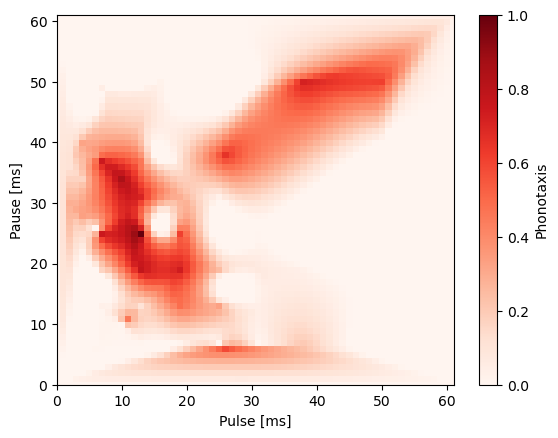

YUC
[30, 19, 1.3, -0.04, 0.15, 10]
0.17391898529875766


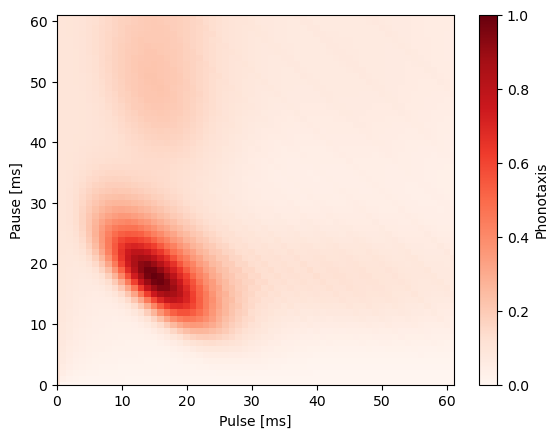

/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
  g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.17077872980331046
                          x: [ 2.910e+01  2.343e+01  5.000e-01 -4.826e-02
                               1.178e-01  9.701e+00]
                        nit: 100
      minimization_failures: 10
                       nfev: 35056
                       njev: 5008
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.17077872980331046
                                    x: [ 2.910e+01  2.343e+01  5.000e-01
                                        -4.826e-02  1.178e-01  9.701e+00]
                                  nit: 39
                                  jac: [ 1.620e-04  9.980e-05 -6.884e-05
                                        -1.372e-03 -4.010e-04 -

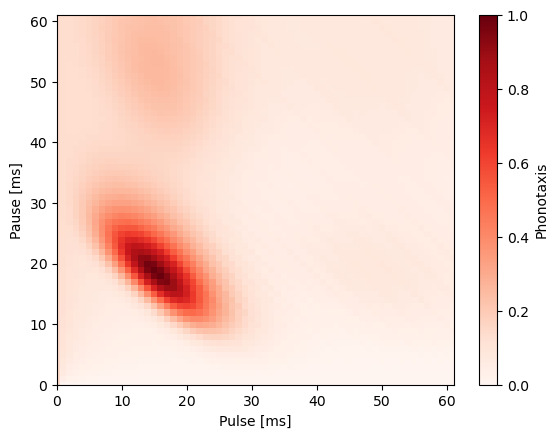

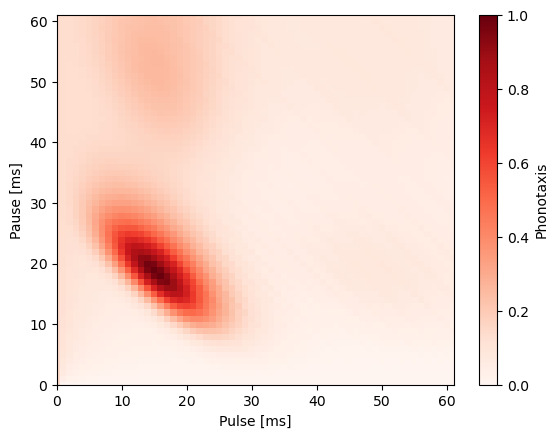

In [70]:
all_results.append(func_call(19))

In [73]:
all_results

[['ADO',
                      message: ['requested number of basinhopping iterations completed successfully']
                      success: True
                          fun: 0.13229753448927442
                            x: [ 1.338e+01  2.086e+01  1.519e+00 -8.175e-02
                                 4.292e-01  3.243e+00]
                          nit: 100
        minimization_failures: 17
                         nfev: 59738
                         njev: 8534
   lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                                success: True
                                 status: 0
                                    fun: 0.13229753448927442
                                      x: [ 1.338e+01  2.086e+01  1.519e+00
                                          -8.175e-02  4.292e-01  3.243e+00]
                                    nit: 45
                                    jac: [ 8.950e-05  3.460e-04  7.773e-04
                    

In [65]:
listin = []
for i in range(19):
    listin.append([res[i][0], res[i][1].fun, res[i][1].x])
l2 = pd.DataFrame(listin)

repeat = []
for i in range(19):
    if l2[1][i]>0.12:
        repeat.append(i)
print(repeat)

[0, 7, 8, 10, 13, 14, 16]


In [66]:
def repeats(rep):
    all_res = []
    if len(rep)==0:
        return all_res
    all_res = Parallel(n_jobs=10)(delayed(func_call)(i) for i in rep)
    
    return all_res


In [67]:
all_results.append(repeats(repeat))

/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp


64.0
1.5
Figure(640x480)
LOC
[12, 120, 1.1, 0.0, 0.0001, 3]
0.21827592925294753
Figure(640x480)
                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.12647615186800895
                          x: [ 1.173e+01  2.771e+01  5.626e-01  6.071e-02
                               1.370e-01  2.018e+01]
                        nit: 100
      minimization_failures: 10
                       nfev: 40397
                       njev: 5771
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.12647615186800895
                                    x: [ 1.173e+01  2.771e+01  5.626e-01
                                         6.071e-02  1.370e-01  2.018e+01]
                                  nit: 46
                                  jac: [

/tmp/ipykernel_28789/901067433.py:6: RuntimeWarning: overflow encountered in exp


16.0
0.25
Figure(640x480)
G15
[90, 4, 1, 0.0, 0.001, 29]
0.1653426716606549
Figure(640x480)
                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.1278323545787776
                          x: [ 1.059e+02  1.143e+00  1.076e+00  7.755e-02
                               1.928e+00  2.630e+01]
                        nit: 100
      minimization_failures: 50
                       nfev: 84371
                       njev: 12053
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.1278323545787776
                                    x: [ 1.059e+02  1.143e+00  1.076e+00
                                         7.755e-02  1.928e+00  2.630e+01]
                                  nit: 43
                                  jac: [ 1.52

KeyboardInterrupt: 

In [74]:
# res = pd.DataFrame(all_results[1])
res = np.array(all_results)

In [182]:
listin = []
for i in range(20):
    listin.append([res[i][0], res[i][1].fun, res[i][1].x[0], res[i][1].x[1], res[i][1].x[2], res[i][1].x[3], res[i][1].x[4], res[i][1].x[5]])
    
l2 = pd.DataFrame(listin)
l2.columns = ['Name', 'f', 'freq', 'sigma', 'phi', 'w', 'a1', 'b1']
l2


,Name,f,freq,sigma,phi,w,a1,b1
0,ADO,0.132298,13.376262,20.857143,1.518860,-0.081745,0.429241,3.242697
1,ANU,0.103918,118.649018,9.039546,0.000000,0.019758,0.250318,38.699411
2,ARM,0.098491,65.016425,8.000000,0.510230,0.071631,0.587036,21.424885
3,BIM,0.091173,27.458635,17.582425,1.497810,-0.004811,0.109000,3.964265
4,FIR,0.070388,17.524898,30.114582,1.858313,-0.050935,0.155554,5.044128
5,G13,0.119058,12.382560,14.285714,0.122223,-0.179372,0.193577,29.448107
6,G14,0.107150,38.517721,10.987292,0.071965,0.002870,0.117935,29.380770
7,G15,0.127832,105.892433,1.142857,1.076207,0.077546,1.928158,26.304785
8,GSP,0.141416,78.631975,2.857143,1.856506,-0.010611,12.811021,100.274876
9,LIN,0.104799,81.769994,5.713767,1.794748,0.025325,2.265666,10.498096


In [183]:
repeats = []
for i in range(20):
    if l2['f'][i]>0.12:
        repeats.append(i)
print(repeats)

[0, 7, 8, 10, 13, 14, 16, 19]


['ADO' 0.13229753448927442]
79.0
1.75


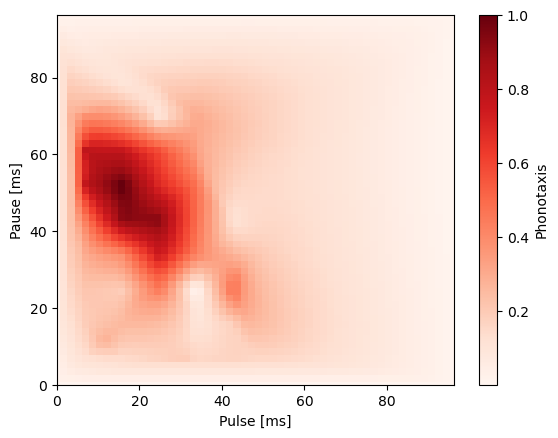

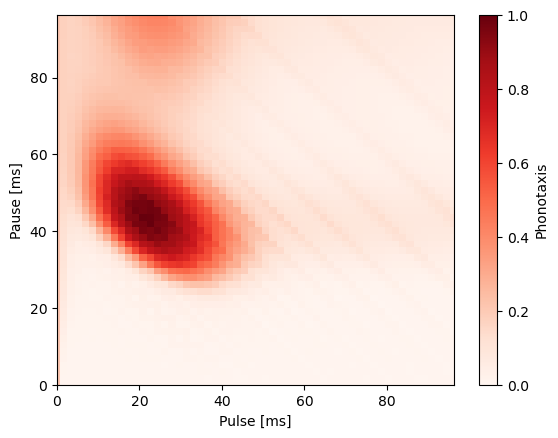

['ANU' 0.10391831103187245]
17.76
0.25


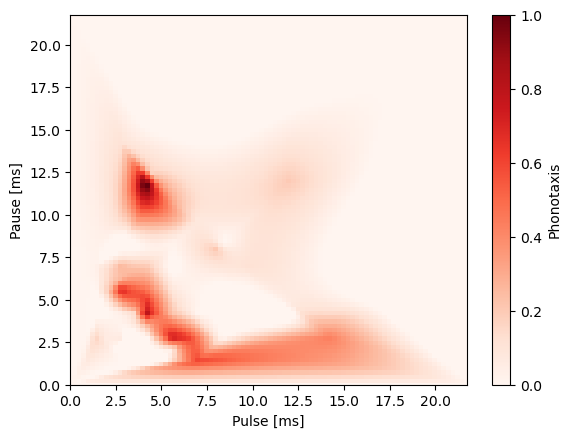

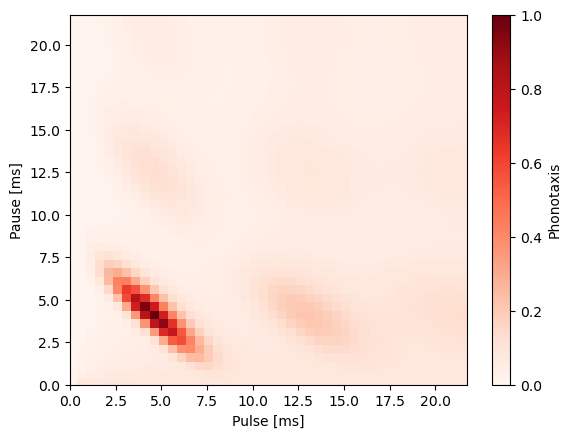

['ARM' 0.09849127473841]
30.0
0.5


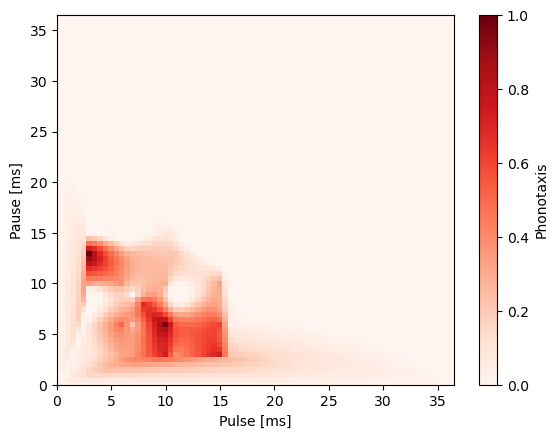

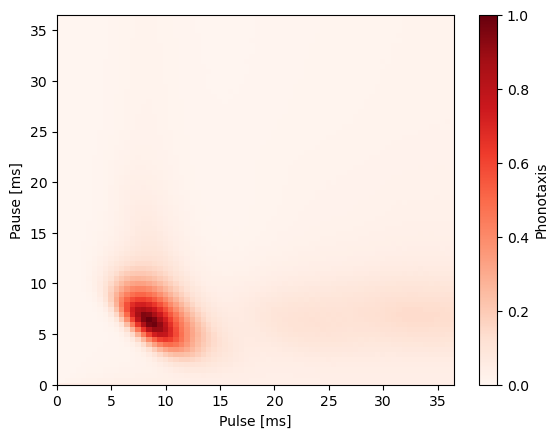

['BIM' 0.09117322611307731]
80.0
2.0


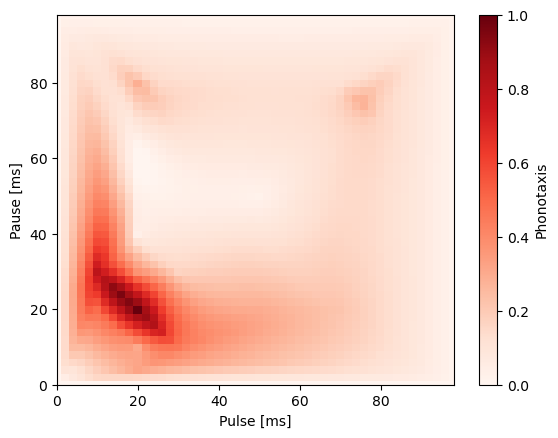

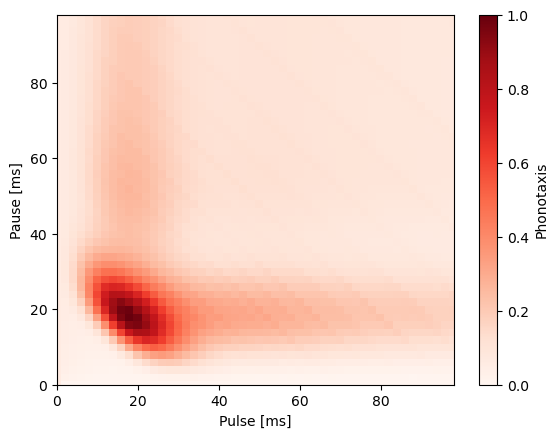

['FIR' 0.07038756344218003]
68.0
1.5


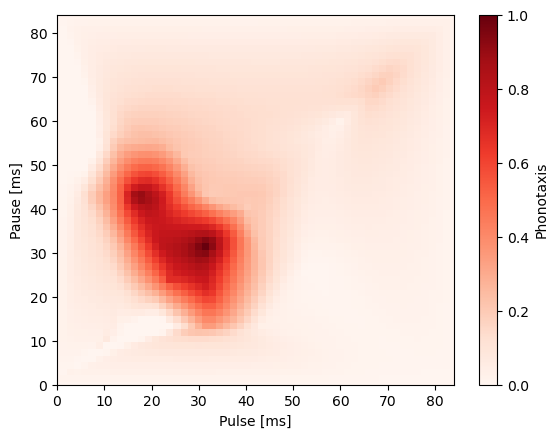

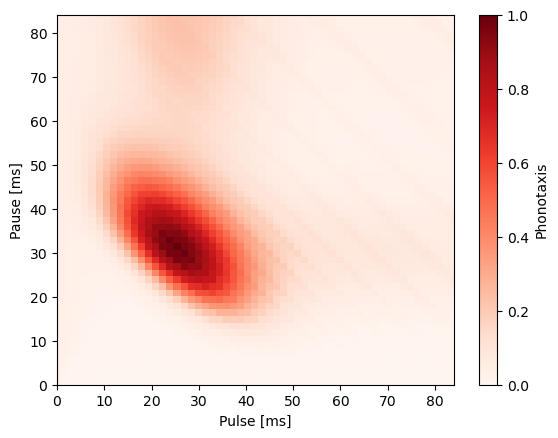

['G13' 0.1190575233641608]
80.0
2.0


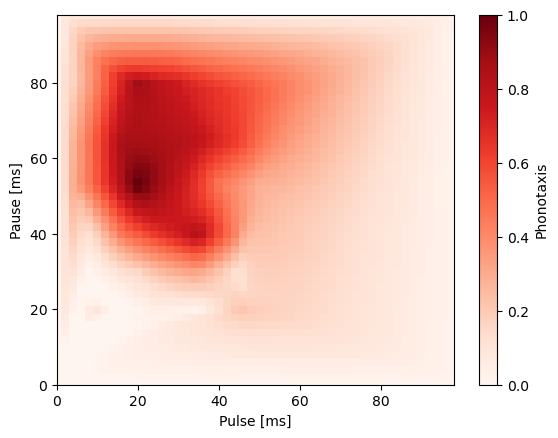

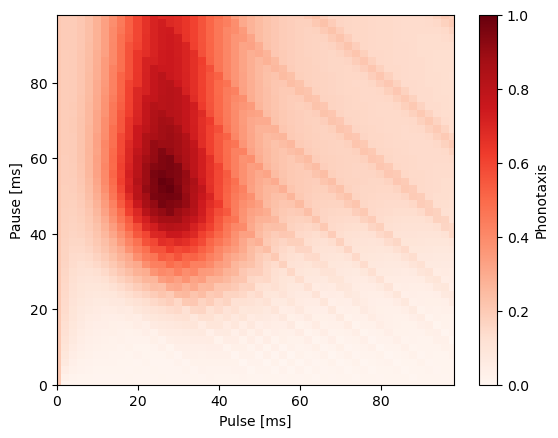

['G14' 0.10715009814061723]
40.0
1.0


/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
  if (np.max(xa[0]) - np.min(xa[0])) > 60:


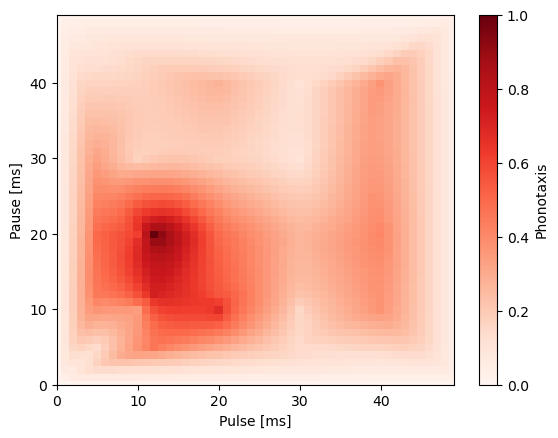

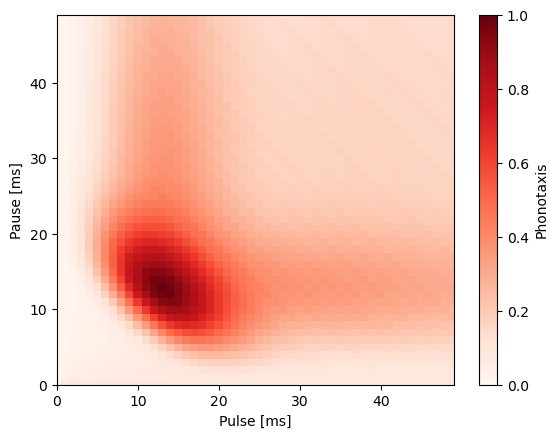

['G15' 0.1278323545787776]
16.0
0.25


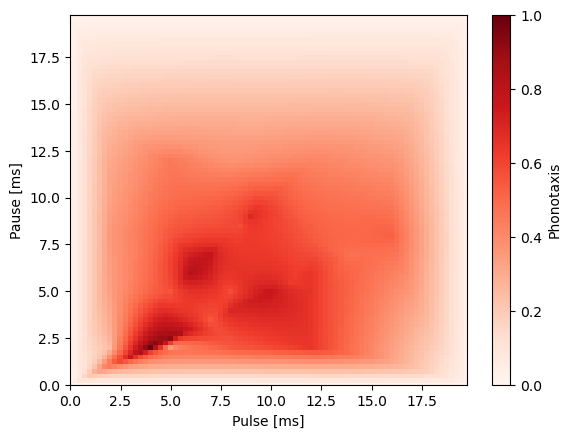

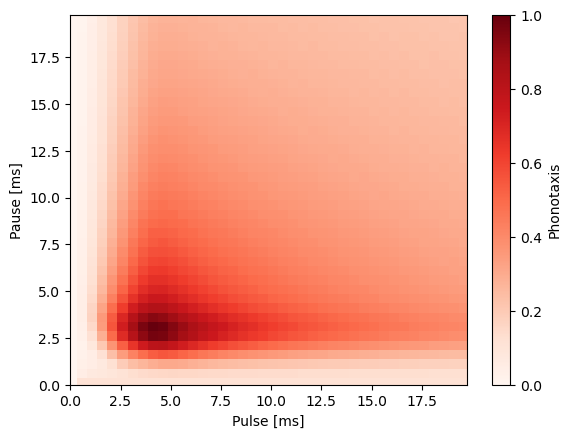

['GSP' 0.14141564363921935]
14.0
0.25


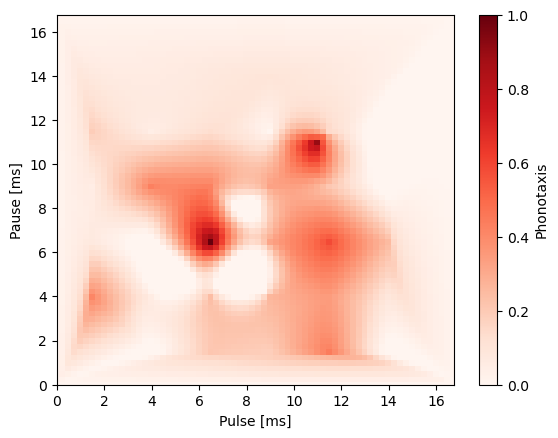

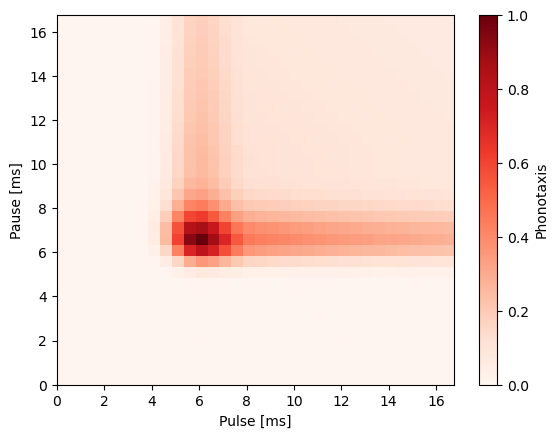

['LIN' 0.1047990266130307]
48.0
1.0


/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
  if (np.max(xa[0]) - np.min(xa[0])) > 60:


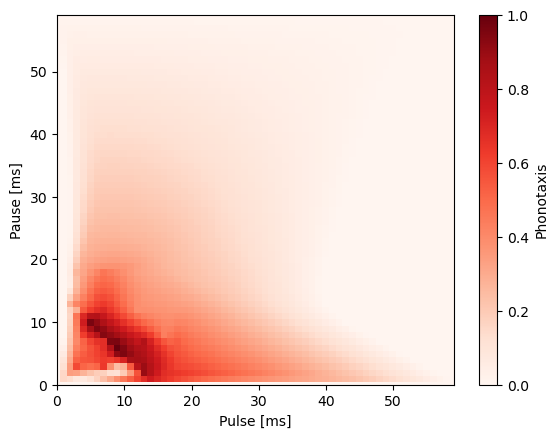

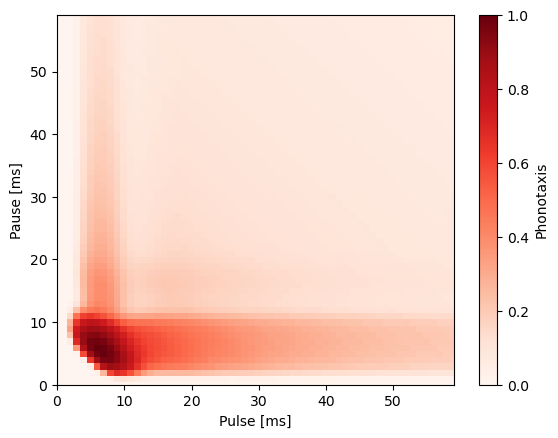

['LOC' 0.12647615186800895]
64.0
1.5


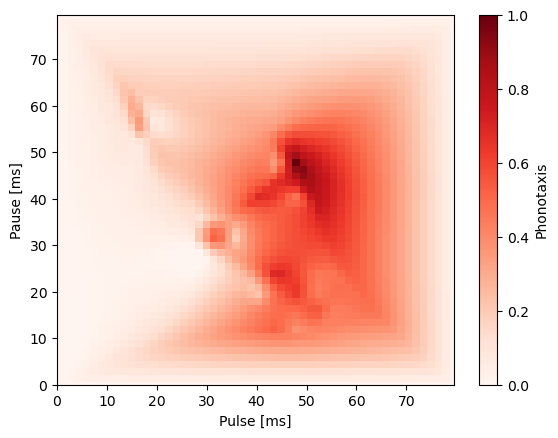

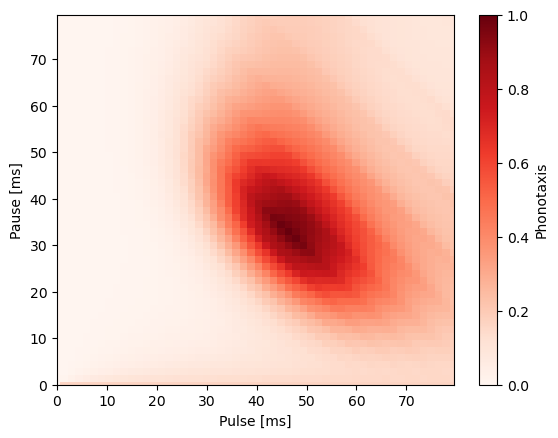

['OAX' 0.0727116448020685]
74.0
1.75


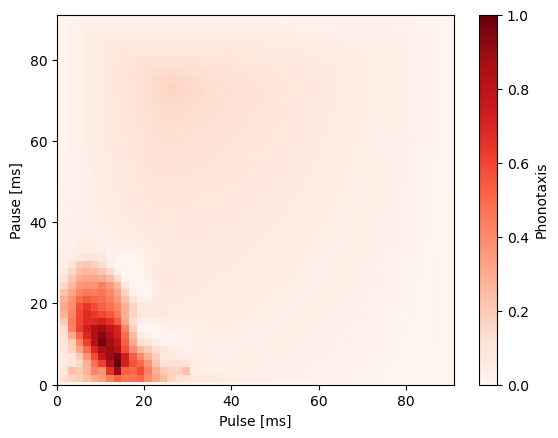

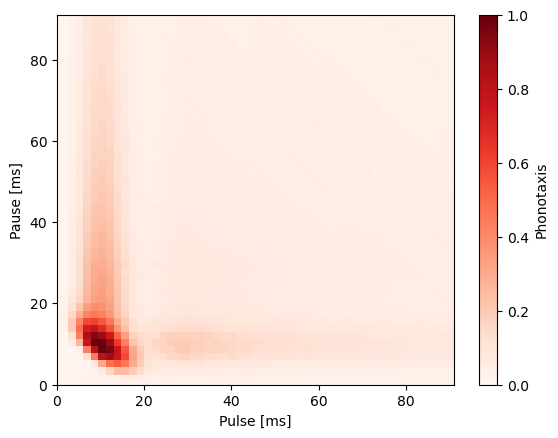

['OVI' 0.07832063256644232]
40.0
1.0


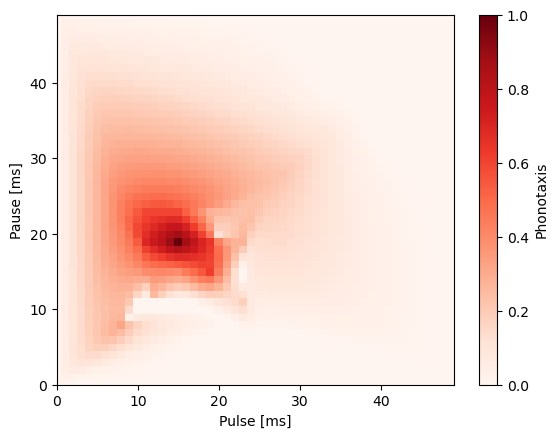

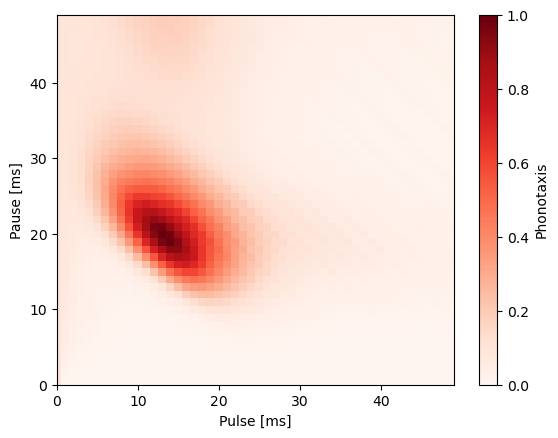

['PER' 0.18290973032517313]
18.0
0.25


/tmp/ipykernel_28789/1455433775.py:40: RuntimeWarning: overflow encountered in long_scalars
  if (np.max(xa[0]) - np.min(xa[0])) > 60:


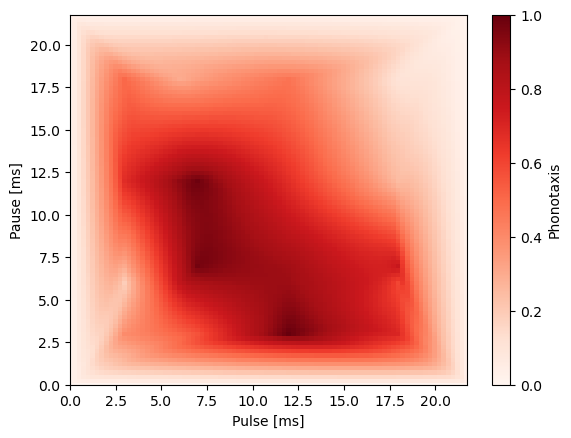

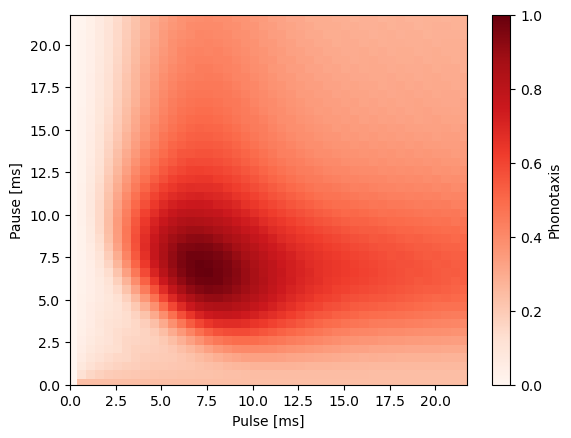

['RUB' 0.17093061840237272]
15.0
0.25


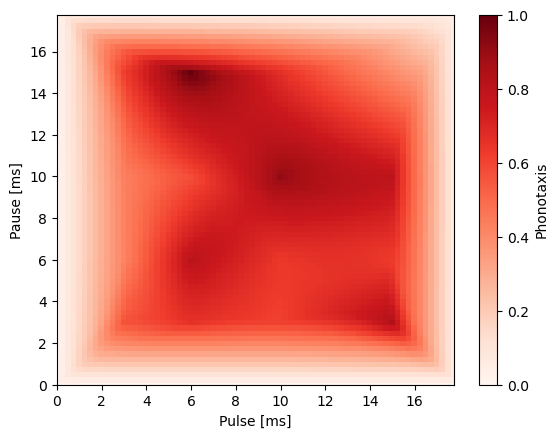

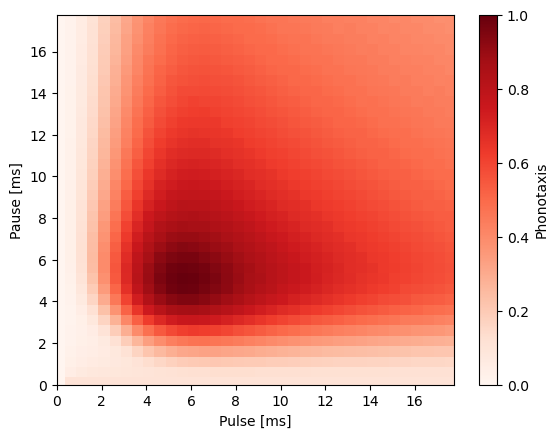

['TEX' 0.11724358427281135]
15.0
0.25


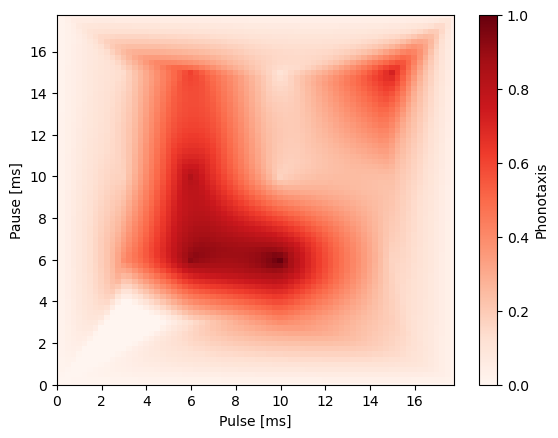

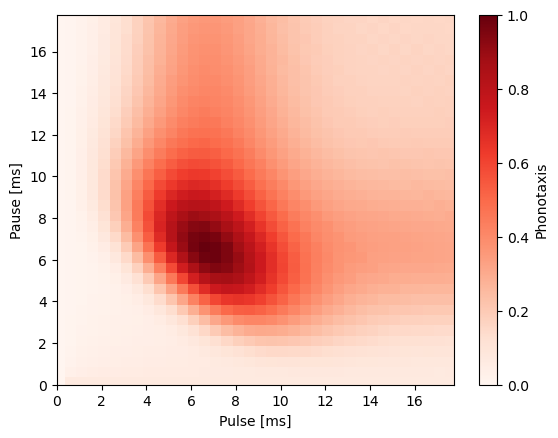

['TUL' 0.15035873952582296]
62.0
1.5


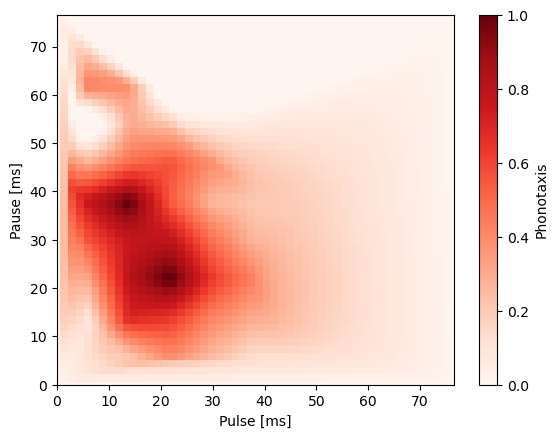

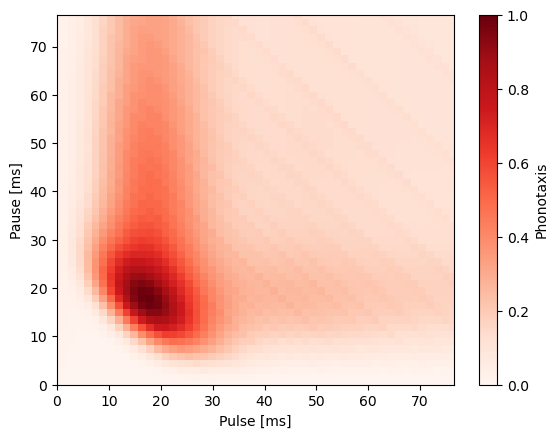

['VEL' 0.10956725292610289]
67.0
1.5


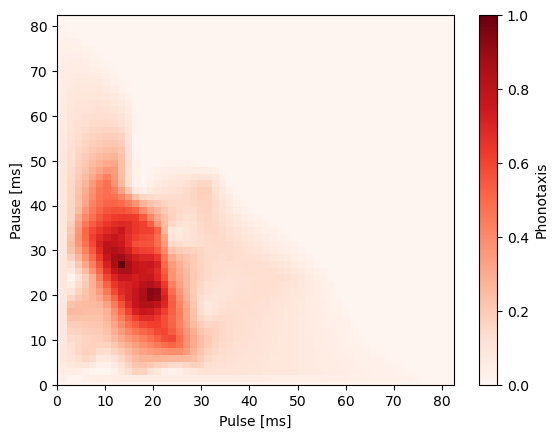

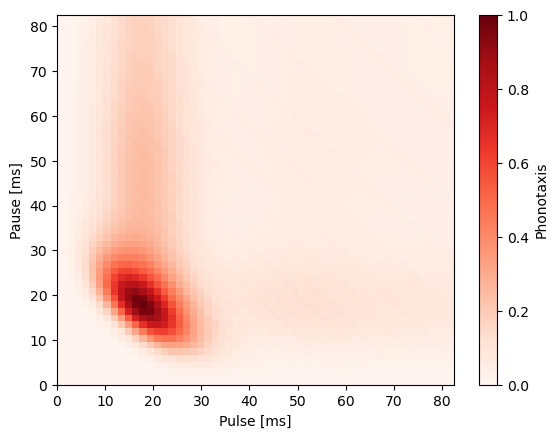

['VOC' 0.09470758099753432]
39.0
0.75


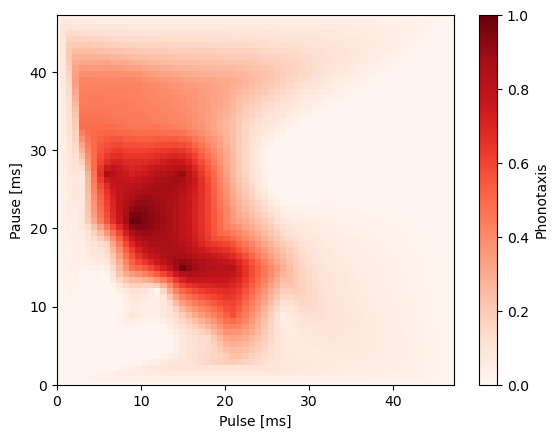

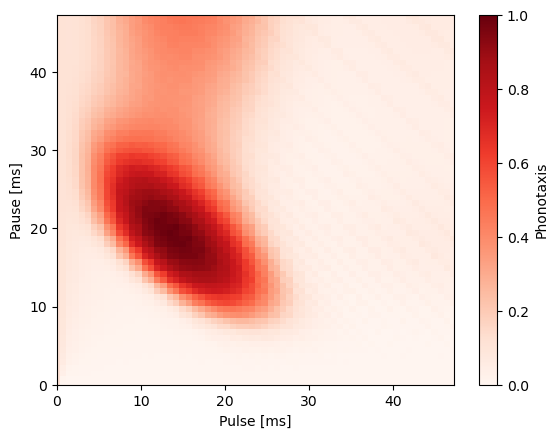

In [184]:
# dfdx = np.array(dfdx)
dtp = np.array([l2['freq'], l2['sigma'], l2['phi'], l2['w'], l2['a1'], l2['b1']])
dtpn = np.array([l2['Name'], l2['f']])
dtp = dtp.T
dtpn = dtpn.T
for i in range(19):
    dataname, data = file_extract()
    name = dtpn[i]
    print(name)
    j = dataname.index(name[0])
    dur_max = 80  # ms
    global pnt_ori, pdur_i, ppau_i
    unpack = import_data(data[j], dur_max)
    pnt_ori = unpack[0]
    dur_max = unpack[1] #in ms
    dur_step = unpack[2] #in ms
    pnt_ori /= np.max(pnt_ori)
    pdur_i, ppau_i = gen_field(dur_max, dur_step)
    plot_field(pdur_i, ppau_i, pnt_ori)
    cfgx = dtp[i]
    xz = sig_diff2(cfgx)
    plot_field(pdur_i, ppau_i, xz[1])
    

In [234]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skbio import DistanceMatrix
from skbio.tree import nj


Explained variation per principal component: [0.43899054 0.26849849 0.13262472] 0.8401137526746341


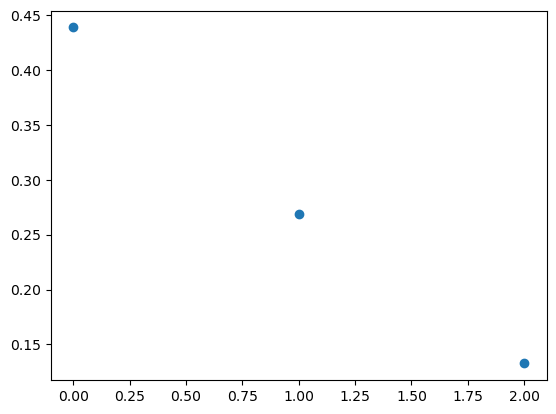

,0,1,2
0,-1.620225,1.624966,-0.172168
1,1.768358,-1.954057,-0.607238
2,1.194778,-0.399692,0.121853
3,-0.970069,1.294766,0.646470
4,-2.148961,1.861175,0.610709
5,-1.659839,-1.245637,-1.611402
6,-0.098540,-1.443538,-0.144974
7,3.442199,0.758310,-0.820651
8,2.538738,2.530206,-1.021339
9,-1.463357,-0.258215,0.926478


In [235]:
dfdx2 = l2.drop(labels = [15, 8], axis = 0)

dfdim = dfdx2.drop(labels = ['Name', 'f'], axis = 1)

features = ['freq', 'sigma', 'phi', 'w', 'a1', 'b1']
x = dfdim.loc[:, features].values
x = StandardScaler().fit_transform(x)
normalised_x = pd.DataFrame(x)

pca_feat = PCA(n_components=3)
principalComponents_feat = pca_feat.fit_transform(x)

feat_Df = pd.DataFrame(data = principalComponents_feat)

vari = pca_feat.explained_variance_ratio_
vari_s = np.sum(vari)
print('Explained variation per principal component: {}'.format(pca_feat.explained_variance_ratio_), vari_s)
plt.plot(vari, 'o')
plt.show()

feat_Df

In [236]:
def distance(x):
    dist = np.sqrt(np.sum(np.square(x)))
    return dist

                    /-VEL
          /--------|
         |         |          /-TUL
         |          \--------|
         |                   |          /-ADO
         |                    \--------|
         |                             |          /-G13
         |                              \--------|
         |                                       |          /-ANU
         |                                        \--------|
         |                                                 |          /-FIR
         |                                                  \--------|
         |                                                           |          /-PER
         |                                                            \--------|
         |                                                                     |          /-LIN
         |                                                                      \--------|
         |                                                      

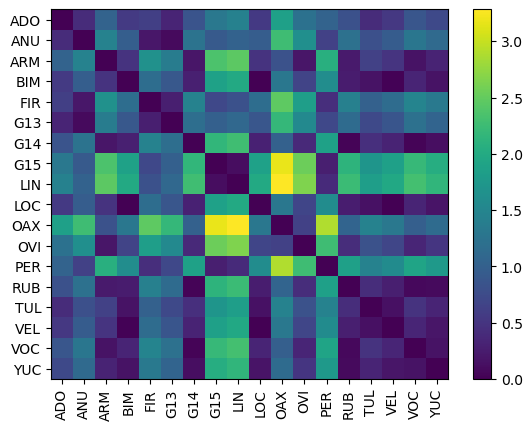

In [238]:
l = feat_Df.shape[0]
distmat = np.ones((l, l))
feats = np.array(feat_Df)

for i in range(0, l):
    for j in range(0, l):
        distmat[i][j] = distance(feats[i]) - distance(feats[j])

distmat = np.absolute(distmat)

ids = list(dfdx2['Name'])
dm = DistanceMatrix(distmat, ids)

tree = nj(dm)
print(tree.ascii_art())
dm

In [240]:
from phylogeny import DistanceMatrix
from phylogeny.reconstruction import infer_clocklike_tree1
from phylogeny.reconstruction import four_point_method

In [241]:
a = pd.DataFrame(distmat)
a.columns = ids
a.index = ids
a.to_csv('distancematrix.txt', header=True, index=True, sep=',', mode='a')

In [242]:
ultrametric = DistanceMatrix(distmat, names = ids)
t = infer_clocklike_tree1(ultrametric)
print(t)



                           /-VOC
                        /-|
                     /-|   \-G14
                    |  |
                  /-|   \-RUB
                 |  |
               /-|   \-YUC
              |  |
              |   \-ARM
              |
            /-|         /-BIM
           |  |      /-|
           |  |   /-|   \-LOC
           |  |  |  |
         /-|   \-|   \-VEL
        |  |     |
        |  |      \-TUL
        |  |
        |   \-OVI
      /-|
     |  |         /-G13
     |  |      /-|
     |  |   /-|   \-ANU
     |  |  |  |
   /-|   \-|   \-FIR
  |  |     |
  |  |      \-ADO
  |  |
  |  |      /-G15
--|  |   /-|
  |   \-|   \-LIN
  |     |
  |      \-PER
  |
   \-OAX
